# Introduction

*Road safety is a very important topic around the world, and in the United Kingdom it's no different. Each year thousands of accidents are reported to the police and details such as location, date, weather, road conditions, and number of causalities are recorded. The consultant, Ian Jeffries, a Data Scientist working for the Department of Transport and Infrastructure, has been tasked with better understanding the root cause of high accident frequencies by "the client". There are three datasets to be analyzed: Accident information from 2017, Casualty information from 2017, and Vehicle information from 2017. These files are freely available for download on data.gov.uk. [1] The goal is to make roads safer for everyone by digging into common denominators and using visualization to make sense of the data. Seven specific questions were posed to the consultant, which will be addressed in the following brief.*

In [46]:
#import necessary packages
import pyspark, os, zipfile
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt

In [32]:
from pyspark.sql import SQLContext
from pyspark import SparkContext

sc = SparkContext("local", "accident_analysis")
sqlCtx = SQLContext(sc)

In [17]:
#perform get request to download files

#get accident data
urllib.request.urlretrieve('http://data.dft.gov.uk.s3.amazonaws.com/road-accidents-safety-data/dftRoadSafetyData_Accidents_2017.zip',
                          'C:/Users/ianke/Desktop/accidents.zip')

#get casualty data
urllib.request.urlretrieve('http://data.dft.gov.uk.s3.amazonaws.com/road-accidents-safety-data/dftRoadSafetyData_Casualties_2017.zip',
                          'C:/Users/ianke/Desktop/casualties.zip')

#get vehicle data
urllib.request.urlretrieve('http://data.dft.gov.uk.s3.amazonaws.com/road-accidents-safety-data/dftRoadSafetyData_Vehicles_2017.zip',
                          'C:/Users/ianke/Desktop/vehicle.zip')

#get dictionary info
urllib.request.urlretrieve('http://data.dft.gov.uk/road-accidents-safety-data/Road-Accident-Safety-Data-Guide.xls',
                          'C:/Users/ianke/Desktop/dictionary.xls')

('C:/Users/ianke/Desktop/dictionary.xls',
 <http.client.HTTPMessage at 0x1af0c0d0160>)

In [19]:
#unzip accident data
accidentZip = zipfile.ZipFile('C:/Users/ianke/Desktop/accidents.zip', 'r')
accidentZip.extractall('C:/Users/ianke/Desktop/')
accidentZip.close()

#unzip casualty data
casualtyZip = zipfile.ZipFile('C:/Users/ianke/Desktop/casualties.zip', 'r')
casualtyZip.extractall('C:/Users/ianke/Desktop/')
casualtyZip.close()

#unzip vehicle data
casualtyZip = zipfile.ZipFile('C:/Users/ianke/Desktop/vehicle.zip', 'r')
casualtyZip.extractall('C:/Users/ianke/Desktop/')
casualtyZip.close()

In [22]:
#delete zip folders
os.remove('C:/Users/ianke/Desktop/accidents.zip')
os.remove('C:/Users/ianke/Desktop/casualties.zip')
os.remove('C:/Users/ianke/Desktop/vehicle.zip')

In [23]:
#read in csv
headerfix = pd.read_csv("C:/Users/ianke/Desktop/Acc.csv", low_memory=False)

#change header name
headerfix = headerfix.rename(columns={'Local_Authority_(District)': 'Local_Authority_District'})

#output csv
headerfix.to_csv("C:/Users/ianke/Desktop/Acc.csv", index=False)

In [41]:
#create accidents Spark dataframe
accidents = sqlCtx.read.option("header","true").csv("C:/Users/ianke/Desktop/Acc.csv")

#create casualties Spark dataframe
casualties = sqlCtx.read.option("header","true").csv("C:/Users/ianke/Desktop/Cas.csv")

#create vehicles Spark dataframe
vehicles = sqlCtx.read.option("header","true").csv("C:/Users/ianke/Desktop/Veh.csv")

In [36]:
#create dictionary variable
dictionary = pd.ExcelFile('C:/Users/ianke/Desktop/dictionary.xls')

#create police force dictionary by specifying the tab of the dictionary variable
policeForcePD = pd.read_excel(dictionary, 'Police Force')

#convert to spark dataframe
policeForce = sqlCtx.createDataFrame(policeForcePD)

In [54]:
#query to get top three police forces (joining accidents dataframe and dictionary dataframe)
top3 = accidents.join(policeForce, accidents.Police_Force == policeForce.code, "left_outer") \
                .select((policeForce.label).alias("police_force")) \
                .where(accidents.Accident_Severity == 1) \
                .groupby("police_force").count().withColumnRenamed("count", "number_of_fatal") \
                .orderBy("Number_of_Fatal", ascending=False) \
                .limit(3)

#show successful query
top3.show()

+-------------------+---------------+
|       police_force|number_of_fatal|
+-------------------+---------------+
|Metropolitan Police|            129|
|      Thames Valley|             59|
|               Kent|             56|
+-------------------+---------------+



In [55]:
top3 = top3.toPandas()

In [56]:
top3.head()

,police_force,number_of_fatal
0,Metropolitan Police,129
1,Thames Valley,59
2,Kent,56


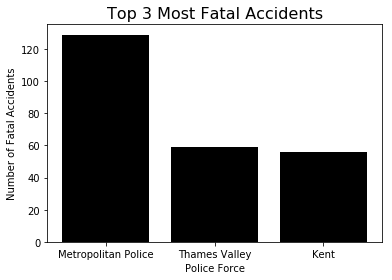

In [57]:
#display visualization in jupyter output inline
%matplotlib inline

#create bar chart
plt.bar(top3.police_force, height=top3.number_of_fatal, color='black')
plt.xlabel('Police Force')
plt.ylabel('Number of Fatal Accidents')
plt.title('Top 3 Most Fatal Accidents', fontdict = {'fontsize' : 16})
plt.style.use('ggplot')
plt.show()